# Notebook 04: Aggregation and Targets

**Traveco Transport Forecasting Project**

## Objective
Create monthly aggregated dataset for time series forecasting:
1. Monthly aggregation by branch
2. Calculate target variables (revenue, external_drivers, personnel_costs)
3. Create time series features
4. Split into train/validation sets (hold out 2024)
5. Verify data quality and aggregation logic

## Outputs
- `data/processed/monthly_aggregated.csv` - Monthly time series data
- Aggregation report and validation metrics

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

# Custom utilities
import sys
sys.path.append('..')  # Add parent directory to path
from utils.traveco_utils import (
    ConfigLoader,
    load_processed_data,
    save_processed_data
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Setup complete!")

Setup complete!


## 2. Load Configuration and Feature-Engineered Data

In [2]:
# Load configuration
config = ConfigLoader('../config/config.yaml')

# Load feature-engineered data from notebook 03
print("Loading feature-engineered data from notebook 03...")
df = load_processed_data(config.get('data.features_engineered'), config)

print(f"\nLoaded {len(df):,} rows with {len(df.columns)} columns")
print(f"\nDate range: {df['Datum.Tour'].min()} to {df['Datum.Tour'].max()}")
print(f"Columns: {list(df.columns[:15])}...")  # Show first 15

Loading feature-engineered data from notebook 03...
Loaded 135,646 rows from: ../data/processed/features_engineered.csv

Loaded 135,646 rows with 117 columns

Date range: 2025-06-01 to 2025-06-30
Columns: ['NummerKomplett.Auftrag', 'Nummer.Hauptauftrag', 'Nummer.Auftrag', 'Datum.Tour', 'Nummer.Tour', 'Tour Bezeichnung', 'Nummer.Auftraggeber', 'Id.Dispostelle', 'AuNr (formatiert)', 'AuNr (Original)', 'Auftrags-art', 'RKdNr.', 'RKdArt', 'RKdName', 'RKdOrt']...


## 3. Identify Target Variables

Define what metrics we want to forecast.

In [3]:
# Target columns from configuration
target_columns_config = config.get('features.target_columns', ['revenue', 'external_drivers', 'personnel_costs'])

print(f"Target metrics to forecast: {target_columns_config}")
print(f"\nIdentifying data sources for targets...\n")

# Map to actual columns that exist in the dataset

target_mappings = {}

# 1. REVENUE: Actual revenue from Column AV
print("1. REVENUE:")
if '∑ Einnahmen' in df.columns:
    print("   ✓ Using actual revenue column: '∑ Einnahmen' (Column AV)")
    print("   → This is the actual revenue made per order")
    target_mappings['revenue'] = '∑ Einnahmen'
else:
    print("   ⚠️  '∑ Einnahmen' not found, using order count as proxy")
    target_mappings['order_count'] = 'Nummer.Auftrag'

# 2. EXTERNAL CARRIER COSTS: Actual costs from Column AX
print("\n2. EXTERNAL CARRIER COSTS:")
if '∑ Ausgaben Spediteur' in df.columns:
    print("   ✓ Using actual external carrier costs: '∑ Ausgaben Spediteur' (Column AX)")
    print("   → This is what Traveco pays to external suppliers (not just count)")
    target_mappings['external_carrier_costs'] = '∑ Ausgaben Spediteur'
else:
    print("   ⚠️  '∑ Ausgaben Spediteur' not found")
    if 'carrier_type' in df.columns:
        print("   → Falling back to external carrier order count")
        target_mappings['external_drivers'] = 'carrier_type'

# 3. TOTAL COSTS: All costs from Column AW
print("\n3. TOTAL COSTS:")
if '∑ Ausgaben Gesamt' in df.columns:
    print("   ✓ Using total costs column: '∑ Ausgaben Gesamt' (Column AW)")
    print("   → This includes all costs related to transport")
    target_mappings['total_costs'] = '∑ Ausgaben Gesamt'
else:
    print("   ⚠️  '∑ Ausgaben Gesamt' not found")

# 4. PERSONNEL COSTS: Data pending from client
print("\n4. PERSONNEL COSTS (PROXY):")
print("   ⚠️  Personnel cost data is PENDING from client")
print("   → Using internal carrier order count as TEMPORARY proxy")
print("   → Assumption: More internal orders = higher personnel costs")
print("   → TODO: Replace with actual personnel cost data when available")
if 'carrier_type' in df.columns:
    target_mappings['internal_drivers_proxy'] = 'carrier_type'

# 5. Distance-based metrics
print("\n5. DISTANCE METRICS:")
if 'Distanz_BE.Auftrag' in df.columns:
    print("   ✓ Billed distance: 'Distanz_BE.Auftrag' (Column CU)")
    print("   → Total distance from orders (billed to customers)")
    target_mappings['total_distance_billed'] = 'Distanz_BE.Auftrag'

# Check if we have tour data for actual driven distance
tour_data_available = False
if 'IstKm.Tour' in df.columns or 'Fahrzeug KM' in df.columns:
    tour_data_available = True
    print("   ✓ Actual driven distance available from tour data")
    print("   → Can calculate efficiency: Actual km / Billed km")
else:
    print("   ℹ️  Actual driven km available in separate tour file")
    print("   → File: '20251015 QS Tourenaufstellung Juni 2025.xlsx'")
    print("   → Column T: 'Soll KM PraCar' (planned km)")
    print("   → Column 20: 'IstKm.Tour' (actual km driven)")
    print("   → Column V: 'IST Zeit PraCar' (actual time)")
    print("   → Link via 'Nummer.Tour' (Column E in orders file)")
    print("   → Tour cost analysis in notebook 06 will merge and analyze efficiency")

print(f"\n📋 Target mappings defined:")
for key, value in target_mappings.items():
    print(f"   {key}: {value}")

Target metrics to forecast: ['revenue', 'external_drivers', 'personnel_costs']

Identifying data sources for targets...

1. REVENUE:
   ✓ Using actual revenue column: '∑ Einnahmen' (Column AV)
   → This is the actual revenue made per order

2. EXTERNAL CARRIER COSTS:
   ✓ Using actual external carrier costs: '∑ Ausgaben Spediteur' (Column AX)
   → This is what Traveco pays to external suppliers (not just count)

3. TOTAL COSTS:
   ✓ Using total costs column: '∑ Ausgaben Gesamt' (Column AW)
   → This includes all costs related to transport

4. PERSONNEL COSTS (PROXY):
   ⚠️  Personnel cost data is PENDING from client
   → Using internal carrier order count as TEMPORARY proxy
   → Assumption: More internal orders = higher personnel costs
   → TODO: Replace with actual personnel cost data when available

5. DISTANCE METRICS:
   ✓ Billed distance: 'Distanz_BE.Auftrag' (Column CU)
   → Total distance from orders (billed to customers)
   ℹ️  Actual driven km available in separate tour file
 

## 4. Monthly Aggregation by Branch

Aggregate order-level data to monthly level for time series forecasting.

In [4]:
# Ensure date column is datetime
df['Datum.Tour'] = pd.to_datetime(df['Datum.Tour'])

# Create year-month column for grouping
df['year_month'] = df['Datum.Tour'].dt.to_period('M')

print(f"Date range in data:")
print(f"  First order: {df['Datum.Tour'].min()}")
print(f"  Last order: {df['Datum.Tour'].max()}")
print(f"  Months covered: {df['year_month'].nunique()}")

# CRITICAL: Use Betriebszentralen names (mapped from Nummer.Auftraggeber)
# Betriebszentralen = 14 dispatch centers that are the actual invoicing units
branch_col = None

if 'betriebszentrale_name' in df.columns:
    branch_col = 'betriebszentrale_name'
    print(f"\n✓ Using '{branch_col}' as branch identifier (CORRECT - Betriebszentralen/dispatch centers)")
    print(f"  These are the 14 invoicing units")
elif 'Nummer.Auftraggeber' in df.columns:
    print(f"\n⚠️  WARNING: 'betriebszentrale_name' not found!")
    print(f"  This means Notebook 03 was not run with Betriebszentralen mapping.")
    print(f"  Solution: Re-run Notebook 03 with updated code")
    print(f"\n  Falling back to Nummer.Auftraggeber (numbers instead of names)")
    branch_col = 'Nummer.Auftraggeber'
else:
    print(f"\n⚠️  No branch column found, will aggregate at overall level only")
    df['branch'] = 'ALL'
    branch_col = 'branch'

if branch_col:
    print(f"  Unique branches: {df[branch_col].nunique()}")
    print(f"  Top 5 branches by order count:")
    print(df[branch_col].value_counts().head())

Date range in data:
  First order: 2025-06-01 00:00:00
  Last order: 2025-06-30 00:00:00
  Months covered: 1

✓ Using 'betriebszentrale_name' as branch identifier (CORRECT - Betriebszentralen/dispatch centers)
  These are the 14 invoicing units
  Unique branches: 12
  Top 5 branches by order count:
betriebszentrale_name
BZ Oberbipp       35980
BZ Sursee         28893
BZ Winterthur     27919
BZ Landquart      16703
B&T Winterthur     9161
Name: count, dtype: int64


In [5]:
# Perform monthly aggregation
print("Performing monthly aggregation...\n")

# Group by year_month and branch (Betriebszentralen)
groupby_cols = ['year_month', branch_col]

agg_dict = {
    'Nummer.Auftrag': 'count',  # Total orders
}

# Add actual financial metrics (UPDATED)
if '∑ Einnahmen' in df.columns:
    agg_dict['∑ Einnahmen'] = 'sum'  # Total revenue
    print("✓ Adding revenue aggregation")

if '∑ Ausgaben Gesamt' in df.columns:
    agg_dict['∑ Ausgaben Gesamt'] = 'sum'  # Total costs
    print("✓ Adding total costs aggregation")

if '∑ Ausgaben Spediteur' in df.columns:
    agg_dict['∑ Ausgaben Spediteur'] = 'sum'  # External carrier costs
    print("✓ Adding external carrier costs aggregation")

# Add distance if available
if 'Distanz_BE.Auftrag' in df.columns:
    agg_dict['Distanz_BE.Auftrag'] = ['sum', 'mean', 'median']

# Count external vs internal carriers
if 'carrier_type' in df.columns:
    # Count external carriers
    df['is_external'] = (df['carrier_type'] == 'external').astype(int)
    df['is_internal'] = (df['carrier_type'] == 'internal').astype(int)
    agg_dict['is_external'] = 'sum'
    agg_dict['is_internal'] = 'sum'

# Improved order type breakdown (including Leergut)
if 'order_type' in df.columns:
    # Create flags for each order type
    df['is_delivery'] = df['order_type'].str.contains('Delivery', case=False, na=False).astype(int)
    df['is_pickup'] = df['order_type'].str.contains('Pickup|Abholung', case=False, na=False).astype(int)
    df['is_leergut'] = df['order_type'].str.contains('Leergut|Empty', case=False, na=False).astype(int)
    df['is_retoure'] = df['order_type'].str.contains('Retoure|Return', case=False, na=False).astype(int)
    
    agg_dict['is_delivery'] = 'sum'
    agg_dict['is_pickup'] = 'sum'
    agg_dict['is_leergut'] = 'sum'
    agg_dict['is_retoure'] = 'sum'

# Add Sparten aggregation if available
if 'sparte' in df.columns:
    # Count number of unique Sparten per month/branch
    agg_dict['sparte'] = 'nunique'

print(f"\nAggregating {len(agg_dict)} metrics by {branch_col}...")

# Aggregate
df_monthly = df.groupby(groupby_cols).agg(agg_dict).reset_index()

# Flatten multi-level columns
df_monthly.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_monthly.columns]

print(f"✓ Monthly aggregation complete")
print(f"  Original rows: {len(df):,}")
print(f"  Aggregated rows: {len(df_monthly):,}")
print(f"  Columns: {list(df_monthly.columns)}")

# Rename columns for clarity (UPDATED with financial metrics)
rename_dict = {
    'Nummer.Auftrag_count': 'total_orders',
    '∑ Einnahmen_sum': 'revenue_total',
    '∑ Ausgaben Gesamt_sum': 'total_costs',
    '∑ Ausgaben Spediteur_sum': 'external_carrier_costs',
    'Distanz_BE.Auftrag_sum': 'total_distance_km',
    'Distanz_BE.Auftrag_mean': 'avg_distance_km',
    'Distanz_BE.Auftrag_median': 'median_distance_km',
    'is_external_sum': 'external_driver_orders',
    'is_internal_sum': 'internal_driver_orders',
    'is_delivery_sum': 'delivery_orders',
    'is_pickup_sum': 'pickup_orders',
    'is_leergut_sum': 'leergut_orders',
    'is_retoure_sum': 'retoure_orders',
    'sparte_nunique': 'unique_sparten_count'
}

df_monthly = df_monthly.rename(columns=rename_dict)

print(f"\n✓ Renamed columns: {list(df_monthly.columns)}")

# Calculate derived metrics
if 'revenue_total' in df_monthly.columns and 'total_costs' in df_monthly.columns:
    df_monthly['profit_margin'] = ((df_monthly['revenue_total'] - df_monthly['total_costs']) / 
                                    df_monthly['revenue_total'] * 100)
    print("\n✓ Calculated profit margin")

if 'revenue_total' in df_monthly.columns and 'total_orders' in df_monthly.columns:
    df_monthly['revenue_per_order'] = df_monthly['revenue_total'] / df_monthly['total_orders']
    print("✓ Calculated revenue per order")

if 'total_costs' in df_monthly.columns and 'total_orders' in df_monthly.columns:
    df_monthly['cost_per_order'] = df_monthly['total_costs'] / df_monthly['total_orders']
    print("✓ Calculated cost per order")

print(f"\n✓ Aggregation by {branch_col} complete")
print(f"  Expected: 14 Betriebszentralen (if betriebszentrale_name was used)")
print(f"  Actual: {df_monthly[branch_col].nunique()} unique branches")

Performing monthly aggregation...

✓ Adding revenue aggregation
✓ Adding total costs aggregation
✓ Adding external carrier costs aggregation

Aggregating 12 metrics by betriebszentrale_name...
✓ Monthly aggregation complete
  Original rows: 135,646
  Aggregated rows: 12
  Columns: ['year_month', 'betriebszentrale_name', 'Nummer.Auftrag_count', '∑ Einnahmen_sum', '∑ Ausgaben Gesamt_sum', '∑ Ausgaben Spediteur_sum', 'Distanz_BE.Auftrag_sum', 'Distanz_BE.Auftrag_mean', 'Distanz_BE.Auftrag_median', 'is_external_sum', 'is_internal_sum', 'is_delivery_sum', 'is_pickup_sum', 'is_leergut_sum', 'is_retoure_sum', 'sparte_nunique']

✓ Renamed columns: ['year_month', 'betriebszentrale_name', 'total_orders', 'revenue_total', 'total_costs', 'external_carrier_costs', 'total_distance_km', 'avg_distance_km', 'median_distance_km', 'external_driver_orders', 'internal_driver_orders', 'delivery_orders', 'pickup_orders', 'leergut_orders', 'retoure_orders', 'unique_sparten_count']

✓ Calculated profit margin


In [6]:
# Show sample of aggregated data
print("\nSample of monthly aggregated data:")
print(df_monthly.head(10))

print(f"\nSummary statistics:")
print(df_monthly.describe())


Sample of monthly aggregated data:
  year_month betriebszentrale_name  total_orders  revenue_total   total_costs  \
0    2025-06         B&T Landquart           599   9.989745e+04  9.987450e+04   
1    2025-06           B&T Puidoux          2444   4.911522e+05  4.672187e+05   
2    2025-06        B&T Winterthur          9161   8.803983e+05  1.097530e+06   
3    2025-06    BZ Herzogenbuchsee          6186   2.775538e+06  2.740018e+06   
4    2025-06  BZ Intermodal / Rail           425   1.754133e+05  2.121609e+05   
5    2025-06          BZ Landquart         16703   7.048027e+05  6.603487e+05   
6    2025-06           BZ Oberbipp         35980   1.289775e+06  1.091089e+06   
7    2025-06            BZ Puidoux          1612   1.577397e+05  1.508678e+05   
8    2025-06             BZ Sierre          5373   2.174266e+05  2.143313e+05   
9    2025-06             BZ Sursee         28893   4.755496e+06  4.704101e+06   

   external_carrier_costs  total_distance_km  avg_distance_km  \
0      

## 5. Add Temporal Features to Monthly Data

In [7]:
# Convert year_month back to datetime for temporal features
df_monthly['date'] = df_monthly['year_month'].dt.to_timestamp()

# Extract temporal features
df_monthly['year'] = df_monthly['date'].dt.year
df_monthly['month'] = df_monthly['date'].dt.month
df_monthly['quarter'] = df_monthly['date'].dt.quarter
df_monthly['month_name'] = df_monthly['date'].dt.month_name()

print("✓ Temporal features added to monthly data")
print(f"\nMonths in dataset: {sorted(df_monthly['year_month'].unique())}")
print(f"Years: {sorted(df_monthly['year'].unique())}")

✓ Temporal features added to monthly data

Months in dataset: [Period('2025-06', 'M')]
Years: [np.int32(2025)]


## 6. Visualize Monthly Trends

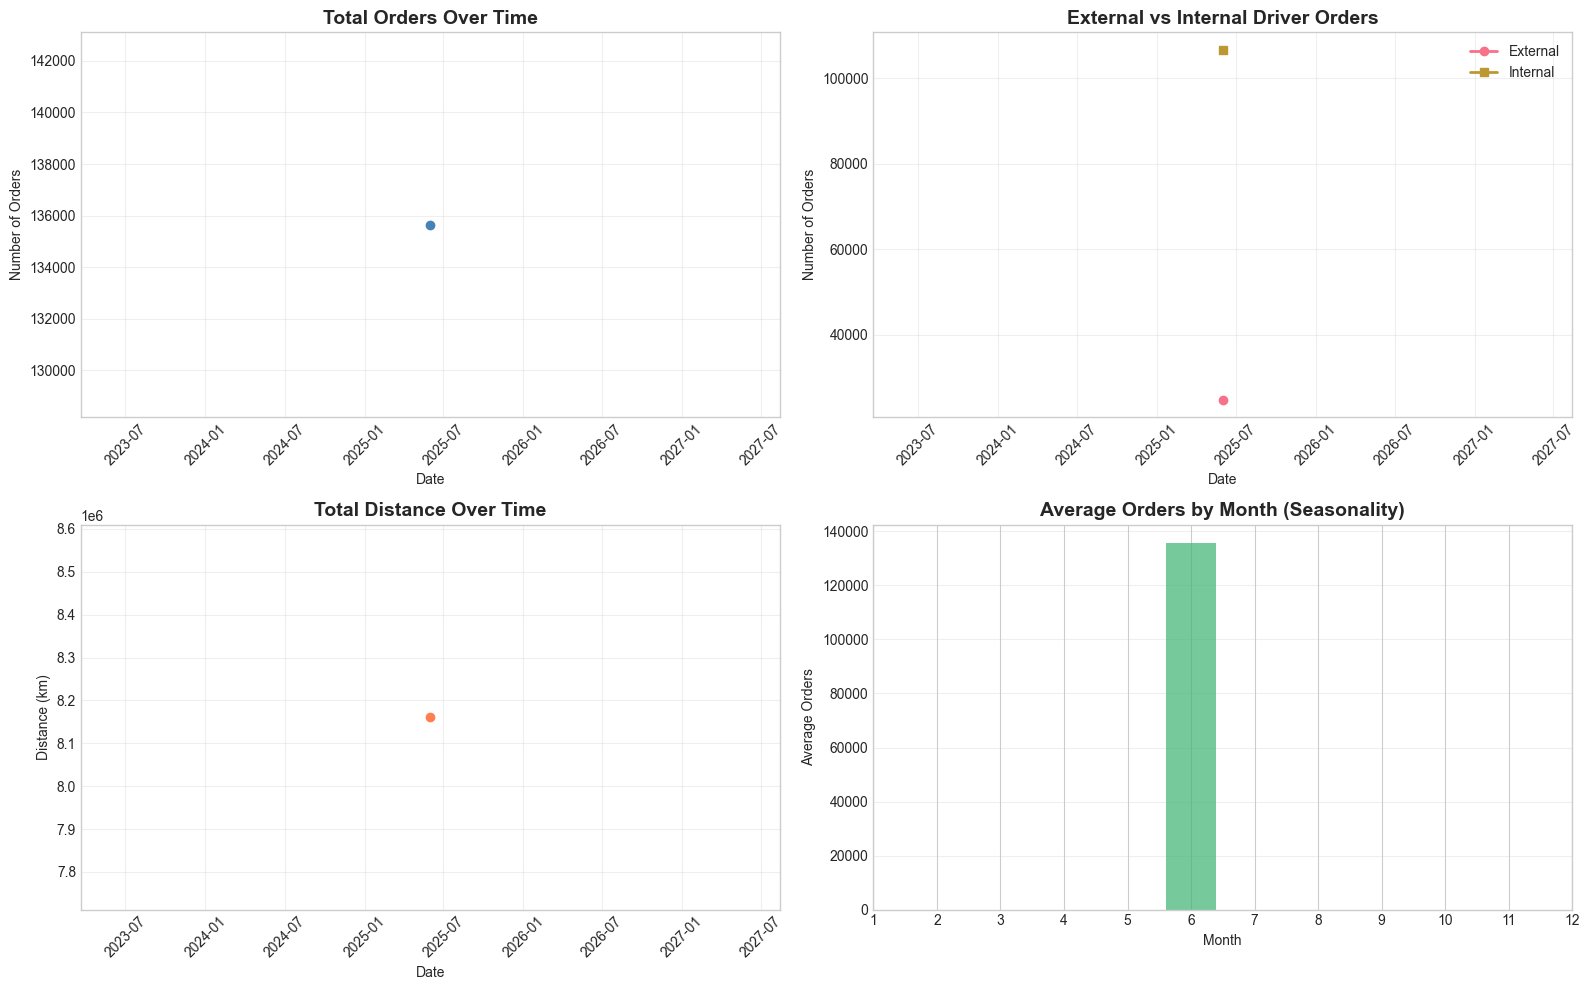


✓ Visualizations complete


In [8]:
# Aggregate across all branches for overall trends
df_monthly_total = df_monthly.groupby('year_month').agg({
    'total_orders': 'sum',
    'external_driver_orders': 'sum' if 'external_driver_orders' in df_monthly.columns else lambda x: 0,
    'internal_driver_orders': 'sum' if 'internal_driver_orders' in df_monthly.columns else lambda x: 0,
    'total_distance_km': 'sum' if 'total_distance_km' in df_monthly.columns else lambda x: 0
}).reset_index()

df_monthly_total['date'] = df_monthly_total['year_month'].dt.to_timestamp()

# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# 1. Total orders over time
axes[0].plot(df_monthly_total['date'], df_monthly_total['total_orders'], marker='o', linewidth=2, color='steelblue')
axes[0].set_title('Total Orders Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Orders')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. External vs Internal drivers
if 'external_driver_orders' in df_monthly_total.columns:
    axes[1].plot(df_monthly_total['date'], df_monthly_total['external_driver_orders'], marker='o', label='External', linewidth=2)
    axes[1].plot(df_monthly_total['date'], df_monthly_total['internal_driver_orders'], marker='s', label='Internal', linewidth=2)
    axes[1].set_title('External vs Internal Driver Orders', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Number of Orders')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

# 3. Total distance over time
if 'total_distance_km' in df_monthly_total.columns:
    axes[2].plot(df_monthly_total['date'], df_monthly_total['total_distance_km'], marker='o', linewidth=2, color='coral')
    axes[2].set_title('Total Distance Over Time', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Distance (km)')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)

# 4. Seasonality (average by month)
df_monthly_total['month'] = df_monthly_total['date'].dt.month
seasonality = df_monthly_total.groupby('month')['total_orders'].mean()
axes[3].bar(seasonality.index, seasonality.values, color='mediumseagreen', alpha=0.7)
axes[3].set_title('Average Orders by Month (Seasonality)', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Month')
axes[3].set_ylabel('Average Orders')
axes[3].set_xticks(range(1, 13))
axes[3].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")

## 7. Branch-Level Analysis

Top 10 branches by total orders:
betriebszentrale_name
BZ Oberbipp           35980
BZ Sursee             28893
BZ Winterthur         27919
BZ Landquart          16703
B&T Winterthur         9161
BZ Herzogenbuchsee     6186
BZ Sierre              5373
B&T Puidoux            2444
BZ Puidoux             1612
B&T Landquart           599
Name: total_orders, dtype: int64


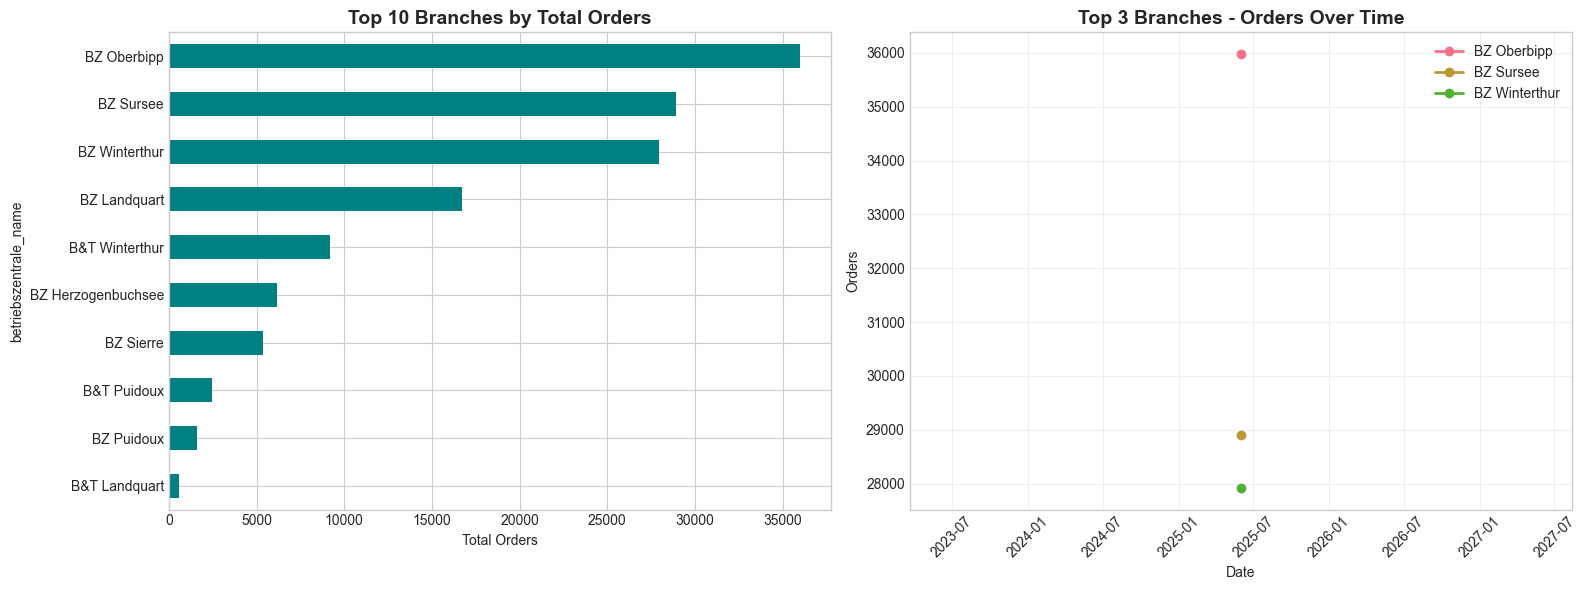

In [9]:
# Analyze top branches
if branch_col and df[branch_col].nunique() > 1:
    # Total orders by branch
    branch_totals = df_monthly.groupby(branch_col)['total_orders'].sum().sort_values(ascending=False)
    
    print("Top 10 branches by total orders:")
    print(branch_totals.head(10))
    
    # Visualize top 10 branches
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    branch_totals.head(10).plot(kind='barh', ax=axes[0], color='teal')
    axes[0].set_title('Top 10 Branches by Total Orders', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Total Orders')
    axes[0].invert_yaxis()
    
    # Time series for top 3 branches
    top_3_branches = branch_totals.head(3).index
    for branch in top_3_branches:
        branch_data = df_monthly[df_monthly[branch_col] == branch]
        branch_data = branch_data.sort_values('year_month')
        axes[1].plot(branch_data['date'], branch_data['total_orders'], marker='o', label=str(branch), linewidth=2)
    
    axes[1].set_title('Top 3 Branches - Orders Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Orders')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("Only one branch - skipping branch comparison")

## 8. Create Train/Validation Split

Hold out 2024 data for validation (if available)

In [10]:
# Check what years we have
years_available = sorted(df_monthly['year'].unique())
print(f"Years available in data: {years_available}")

# Determine validation year
validation_year = config.get('validation.holdout_year', 2024)

if validation_year in years_available:
    # Split into train and validation
    df_train = df_monthly[df_monthly['year'] < validation_year].copy()
    df_val = df_monthly[df_monthly['year'] == validation_year].copy()
    
    print(f"\n✓ Train/Validation split created:")
    print(f"  Training data: {len(df_train)} months ({df_train['year'].min()}-{df_train['year'].max()})")
    print(f"  Validation data: {len(df_val)} months ({validation_year})")
    
    # Add split indicator to main dataframe
    df_monthly['split'] = df_monthly['year'].apply(lambda x: 'train' if x < validation_year else 'validation')
else:
    print(f"\n⚠️  Validation year {validation_year} not in data")
    print(f"  Will use time series cross-validation during modeling")
    df_monthly['split'] = 'train'
    df_train = df_monthly.copy()
    df_val = pd.DataFrame()  # Empty validation set

Years available in data: [np.int32(2025)]

⚠️  Validation year 2024 not in data
  Will use time series cross-validation during modeling


## 9. Data Quality Checks

In [11]:
print("=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# 1. Check for missing months
print("\n1. COMPLETENESS:")
date_range = pd.period_range(start=df_monthly['year_month'].min(), end=df_monthly['year_month'].max(), freq='M')
expected_months = len(date_range)
actual_months = df_monthly['year_month'].nunique()
print(f"   Expected months: {expected_months}")
print(f"   Actual months: {actual_months}")
if expected_months == actual_months:
    print("   ✓ No missing months")
else:
    missing_months = set(date_range) - set(df_monthly['year_month'].unique())
    print(f"   ⚠️  Missing months: {missing_months}")

# 2. Check for zero/null values in key metrics
print("\n2. KEY METRICS:")
for col in ['total_orders', 'external_driver_orders', 'internal_driver_orders']:
    if col in df_monthly.columns:
        zeros = (df_monthly[col] == 0).sum()
        nulls = df_monthly[col].isnull().sum()
        print(f"   {col}:")
        print(f"      Zeros: {zeros} ({zeros/len(df_monthly)*100:.1f}%)")
        print(f"      Nulls: {nulls}")

# 3. Check for outliers
print("\n3. OUTLIERS (Total Orders):")
Q1 = df_monthly['total_orders'].quantile(0.25)
Q3 = df_monthly['total_orders'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_monthly['total_orders'] < (Q1 - 3*IQR)) | 
            (df_monthly['total_orders'] > (Q3 + 3*IQR))).sum()
print(f"   Extreme outliers (>3 IQR): {outliers}")

# 4. Summary statistics
print("\n4. SUMMARY STATISTICS:")
print(df_monthly[['total_orders']].describe())

print("\n" + "=" * 80)

DATA QUALITY CHECKS

1. COMPLETENESS:
   Expected months: 1
   Actual months: 1
   ✓ No missing months

2. KEY METRICS:
   total_orders:
      Zeros: 0 (0.0%)
      Nulls: 0
   external_driver_orders:
      Zeros: 4 (33.3%)
      Nulls: 0
   internal_driver_orders:
      Zeros: 0 (0.0%)
      Nulls: 0

3. OUTLIERS (Total Orders):
   Extreme outliers (>3 IQR): 0

4. SUMMARY STATISTICS:
       total_orders
count     12.000000
mean   11303.833333
std    12844.527649
min      351.000000
25%     1358.750000
50%     5779.500000
75%    19507.000000
max    35980.000000



## 10. Save Monthly Aggregated Data

In [12]:
# Convert period to string for CSV saving
df_monthly['year_month'] = df_monthly['year_month'].astype(str)

# Save to processed data folder
output_filename = config.get('data.monthly_aggregated', 'monthly_aggregated.csv')

print(f"Saving monthly aggregated dataset...")
save_processed_data(df_monthly, output_filename, config)

print(f"\n✓ Monthly aggregated dataset saved successfully!")
print(f"  Location: data/processed/{output_filename}")
print(f"  Rows: {len(df_monthly):,}")
print(f"  Columns: {len(df_monthly.columns)}")

Saving monthly aggregated dataset...
Saved 12 rows to: ../data/processed/monthly_aggregated.csv

✓ Monthly aggregated dataset saved successfully!
  Location: data/processed/monthly_aggregated.csv
  Rows: 12
  Columns: 25


## 11. Generate Aggregation Report

In [13]:
# Create aggregation report
import json

aggregation_report = {
    'input_data': {
        'total_orders': int(len(df)),
        'date_range': {
            'start': str(df['Datum.Tour'].min()),
            'end': str(df['Datum.Tour'].max())
        }
    },
    'aggregated_data': {
        'total_months': int(len(df_monthly)),
        'branches': int(df_monthly[branch_col].nunique()) if branch_col else 1,
        'years_covered': [int(y) for y in sorted(df_monthly['year'].unique())],
        'columns': list(df_monthly.columns)
    },
    'metrics': {
        'total_orders': {
            'mean': float(df_monthly['total_orders'].mean()),
            'median': float(df_monthly['total_orders'].median()),
            'min': int(df_monthly['total_orders'].min()),
            'max': int(df_monthly['total_orders'].max()),
            'std': float(df_monthly['total_orders'].std())
        }
    },
    'train_val_split': {
        'validation_year': validation_year,
        'train_months': int(len(df_train)) if not df_train.empty else 0,
        'val_months': int(len(df_val)) if not df_val.empty else 0
    }
}

# Add distance metrics if available
if 'total_distance_km' in df_monthly.columns:
    aggregation_report['metrics']['total_distance_km'] = {
        'mean': float(df_monthly['total_distance_km'].mean()),
        'median': float(df_monthly['total_distance_km'].median()),
        'min': float(df_monthly['total_distance_km'].min()),
        'max': float(df_monthly['total_distance_km'].max())
    }

# Save report
results_path = Path('../results')
results_path.mkdir(exist_ok=True)

with open(results_path / 'aggregation_report.json', 'w') as f:
    json.dump(aggregation_report, f, indent=2)

print("✓ Aggregation report saved to: results/aggregation_report.json")

✓ Aggregation report saved to: results/aggregation_report.json


## 12. Summary and Next Steps

In [14]:
print("=" * 80)
print("AGGREGATION SUMMARY")
print("=" * 80)

print(f"\n📊 DATA TRANSFORMATION:")
print(f"   Original (order-level): {len(df):,} rows")
print(f"   Aggregated (monthly): {len(df_monthly):,} rows")
print(f"   Reduction: {(1 - len(df_monthly)/len(df))*100:.1f}%")

print(f"\n📅 TIME COVERAGE:")
print(f"   Months: {df_monthly['year_month'].nunique()}")
print(f"   Years: {', '.join(map(str, sorted(df_monthly['year'].unique())))}")
print(f"   Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")

print(f"\n🏢 BRANCHES:")
if branch_col:
    print(f"   Total branches: {df_monthly[branch_col].nunique()}")

print(f"\n🎯 TARGET METRICS:")
print(f"   - total_orders: Order count (revenue proxy)")
if 'external_driver_orders' in df_monthly.columns:
    print(f"   - external_driver_orders: External carrier usage")
if 'internal_driver_orders' in df_monthly.columns:
    print(f"   - internal_driver_orders: Internal carrier usage (personnel cost proxy)")
if 'total_distance_km' in df_monthly.columns:
    print(f"   - total_distance_km: Total distance traveled")

print(f"\n🔀 TRAIN/VALIDATION SPLIT:")
print(f"   Training: {len(df_train):,} months")
print(f"   Validation: {len(df_val):,} months")

print(f"\n💾 OUTPUT:")
print(f"   File: data/processed/{output_filename}")
print(f"   Ready for forecasting models!")

print(f"\n➡️  NEXT STEPS:")
print(f"   Proceed to notebook 05: Exploratory Data Analysis")
print(f"   - Seasonal decomposition")
print(f"   - Trend analysis")
print(f"   - Correlation analysis")
print(f"   - Pattern identification")

print("\n" + "=" * 80)

AGGREGATION SUMMARY

📊 DATA TRANSFORMATION:
   Original (order-level): 135,646 rows
   Aggregated (monthly): 12 rows
   Reduction: 100.0%

📅 TIME COVERAGE:
   Months: 1
   Years: 2025
   Date range: 2025-06-01 00:00:00 to 2025-06-01 00:00:00

🏢 BRANCHES:
   Total branches: 12

🎯 TARGET METRICS:
   - total_orders: Order count (revenue proxy)
   - external_driver_orders: External carrier usage
   - internal_driver_orders: Internal carrier usage (personnel cost proxy)
   - total_distance_km: Total distance traveled

🔀 TRAIN/VALIDATION SPLIT:
   Training: 12 months
   Validation: 0 months

💾 OUTPUT:
   File: data/processed/monthly_aggregated.csv
   Ready for forecasting models!

➡️  NEXT STEPS:
   Proceed to notebook 05: Exploratory Data Analysis
   - Seasonal decomposition
   - Trend analysis
   - Correlation analysis
   - Pattern identification



---

## Conclusion

This notebook successfully created monthly aggregated time series data:
- **Aggregated** order-level data to monthly level by branch
- **Calculated** target metrics: total orders, external/internal drivers, distance
- **Visualized** trends and seasonality patterns
- **Created** train/validation split
- **Validated** data quality and completeness

**Next:** Proceed to `05_exploratory_data_analysis.ipynb` for deeper pattern analysis.